In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  #  75 W- 100W 48.75-50.00 dBm
jam_power_dbm = 60
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

N0 = noise_power_watt
T_sys = 300.0  # K  realistic mid-value for LEO sat RX
N0 = 1.38e-23 * 100e6 * T_sys 
P0 = Tx_power_watt
P1 = Jam_power_watt
import matplotlib.pyplot as plt
import mitsuba as mi
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np
from tqdm.notebook import tqdm

from Dishjammersolver import optimal_Q0
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
from numpy.linalg import cholesky, solve, eigh

from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver, load_scene, RadioMapSolver
import vsat_dish_3gpp
from BeamformingCalc import svd_bf, nulling_bf,left_singular_u1, nulling_bf_fast_scipy
# Generate RX positions

# distances_km = [jam_dist]




# Compute SAT intersection points

sat_orbit_m = 550e3
# angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(345.49,65.65), (272.81, 60.03)]
angles = [(1, 90-(1e-9))]
# angles = [(45, 90-(1e-3)), (120, 87), (75,85),(80,83), (65, 82),(130,80)]
# angles = [(45, 90-(1e-3)), (220, 87), (75,85)]
sat_positions = []
for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)

sat_positions = np.array(sat_positions)
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz




def compute_cir(tx_pos, rx_pos, tx_array, rx_array, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = load_scene()
    scene.frequency = frequency
    scene.synthetic_array = True
    
    
    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
        
        
    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, power_dbm=70)
    scene.add(tx)

    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    # earth_radius_m = 6371e3
    # rx_look_at = np.array([0.0, 0.0, -1*earth_radius_m/2])
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(tx)
        rx_list.append(rx)
    # tx_look_at2 = np.array(tx_pos) + np.array([0.0, 0.0, 100.0])
    tx.look_at( np.array([0,0,1]))  # Point TX to the first RX

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")


    
    return a_all, tau_all, scene


jam_rows = 1
jam_cols = 1
jam_antennas = jam_cols*jam_rows

sat_rows = 8
sat_cols = 8
sat_antennas = sat_cols*sat_rows

tx_rows = 6
tx_cols = 6
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                            pattern="vsat_dish",
                            # pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="tr38901",
                            # pattern="iso",
                             polarization="V")
def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t




def channel_capacity_multi_jammers(H_sig,w_t, w_r, P0, H_jams, P1,N0):

    H_sig = H_sig.T
    g_sig = (w_r.conj().T @ H_sig @ w_t)
    S = (np.abs(g_sig) ** 2) * (P0)
    I_total = 0
    H_jams = H_jams.T
    for i in range (H_jams.shape[1]):
        hjam = H_jams[:,i].reshape(-1, 1)
        I_total += (np.abs((w_r.conj().T @ hjam)) ** 2) *(P1)
    denom = I_total+N0
    sinr = (S / denom)
    sinr_db = 10*np.log10(sinr).item()
    inr_db = 10*np.log10(I_total/N0).item()
    C = np.log2(1.0 + sinr).item()

    return C, sinr_db, inr_db





jitc_llvm_init(): LLVM API initialization failed ..


In [2]:
# =========================
# Sweep over jam_dist ∈ {1,5,10,15,20,25} km with per-radius lambda_
# =========================

from Dishjammersolver import optimal_Q0
import mitsuba as mi

# Q0, Q1, _, C_water = optimal_Q0( H_tx.T, H_jam.T, N0, P0, P1)

# 全局 Python 层随机
# os.environ["PYTHONHASHSEED"] = "0"
# np.random.seed(42)
# random.seed(42)
    
# --- choose your λ per radius (EDIT these as you like) ---
# lambda_map = {
#     1:  100,
#     5:  100,
#     10: 100,
#     15: 100,
#     20: 100,
#     25: 100,
# }
lambda_map = {
    1:  0.1,
    5:  0.1,
    10: 40,
    15: 100,
    20: 200,
    25: 300,
}
# lambda_map = {
#     1:  10,
#     5:  10,
#     10: 10,
#     15: 10,
#     20: 10,
#     25: 10,
# }



radii_km = [1, 5, 10, 15, 20, 25]

# For each radius we will place 8 jammers uniformly on a circle
n_jammers_on_circle = 4
azimuths_deg_all = np.linspace(0, 360, n_jammers_on_circle, endpoint=False)

# storage
cap_by_radius = []
cap_by_radius2 = []
sinr_db_by_radius = []
inr_db_by_radius = []
images_by_radius = []     # store rendered radio-map images as numpy arrays
titles_by_radius = []

# Common settings for radio map plot size
Lx, Ly = 60e3, 60e3   # +/- 30 km
extent_km = [-Lx/2/1e3, Lx/2/1e3, -Ly/2/1e3, Ly/2/1e3]

# === Helper to (re)build ground TX + jammers for a given radius ===
def make_ground_positions(radius_km):
    gp = [np.array([0.0, 0.0, 0.0])]  # TX at origin
    for az in azimuths_deg_all:
        gp.append(arc_point_on_earth(radius_km, az))
    return np.asarray(gp)





# === Begin sweep ===
for r_km in radii_km:
    lambda_ = lambda_map[r_km]

    # ---- geometry for this radius ----
    gnd_positions = make_ground_positions(r_km)      # (1 + J, 3)
    J = gnd_positions.shape[0] - 1                   # number of jammers

    # ---- compute channels (TX->SAT and JAM->SAT) ----
    # desired user = index 0
    a_tx, tau_tx, scene_tx = compute_cir(
        sat_positions[0], gnd_positions[0, :].reshape(1, -1), sat_array, tx_array
    )
    a_jam, tau_jam, scene_jam = compute_cir(
        sat_positions[0], gnd_positions[1:, :], sat_array, jam_array
    )

    H_tx  = collapse_channel(a_tx)   # (Nrx_total, Ntx_total)
    H_jam = collapse_channel(a_jam)  # (Nrx_total, J*Nj_tx) but we reshape below if needed

    # Ensure shapes as expected by your earlier code:
    # You used H_tx as (Ntx, Nrx) before calling svd_bf/nulling_bf with H_tx.T
    # Here collapse_channel returns (Nrx, Ntx) so we keep consistent with your previous pattern:
    # H_tx_for_svd = H_tx.T            # -> (Ntx, Nrx)
    _, w_tx = svd_bf(H_tx)   # your helper gives right-singular vector

    # Build interference covariance on the satellite side (receive side):
    interference_term = H_jam.conj().T @ H_jam

    # Nulling beam (receiver-side) with your routine; you previously called nulling_bf(H.T, w_t, ...)
    w_null, _, _, _ = nulling_bf(H_tx.T, w_tx, interference_term, lambda_)

    # ---- capacity / SINR for this radius ----
    C, sinr_db, inr_db = channel_capacity_multi_jammers(
        H_sig=H_tx, w_t=w_tx, w_r=w_null, P0=P0, H_jams=H_jam, P1=P1, N0=N0
    )
    cap_by_radius.append(C)
    sinr_db_by_radius.append(sinr_db)
    inr_db_by_radius.append(inr_db)
    Q0, Q1, _, C_water = optimal_Q0( H_tx.T, H_jam.T, N0, P0, P1)
    cap_by_radius2.append(C_water)

    # ---- radio map rendering on this radius ----
    # Build a fresh scene and use w_null as the satellite precoder (your earlier pattern)
    scene = load_scene()
    scene.frequency = fc
    scene.bandwidth = 100e6
    scene.synthetic_array = True

    for tx_name in list(scene.transmitters):
        scene.remove(tx_name)
    for rx_name in list(scene.receivers):
        scene.remove(rx_name)

    scene.tx_array = sat_array
    tx = Transmitter(name="tx", position=sat_positions[0], power_dbm=70)
    scene.add(tx)
    tx.look_at(np.array([0, 0, 1]))

    
    precoding_vec = (mi.TensorXf(w_null.real), mi.TensorXf(w_null.imag))

    rm_solver = RadioMapSolver()
    rm = rm_solver(
        scene,
        max_depth=0,
        samples_per_tx=10**9,  # lower than 1e9 for speed; raise if you want smoother maps
        precoding_vec=precoding_vec,
        cell_size=(100, 100),
        center=[0, 0, 1],
        size=[Lx, Ly],
        orientation=[0, 0, 0] )

    # We call rm.show() to get the rendered image, then extract its array for our 2x3 panel
    # fig_tmp = rm.show(metric="path_gain")
    # ax_tmp = fig_tmp.axes[0]
    # im_tmp = ax_tmp.images[0]
    # img_array = im_tmp.get_array()    # This is the rendered data
    # plt.close(fig_tmp)

    # images_by_radius.append(img_array)
    # titles_by_radius.append(f"r={r_km} km, λ={lambda_}, C={C:.2f} b/s/Hz")
    
    fig_tmp = rm.show(metric="path_gain")
    ax_tmp = fig_tmp.axes[0]
    im_tmp = ax_tmp.images[0]
    img_array = im_tmp.get_array()

    # —— detach：拷贝成独立 numpy 数组，确保后续不被 Matplotlib 状态影响 —— 
    img_array = np.array(img_array, dtype=float, copy=True)

    plt.close(fig_tmp)

    images_by_radius.append(img_array)
    # titles_by_radius.append(f"r={r_km} km, λ={lambda_}, C={C:.2f} b/s/Hz")
    titles_by_radius.append(f"r={r_km} km ")




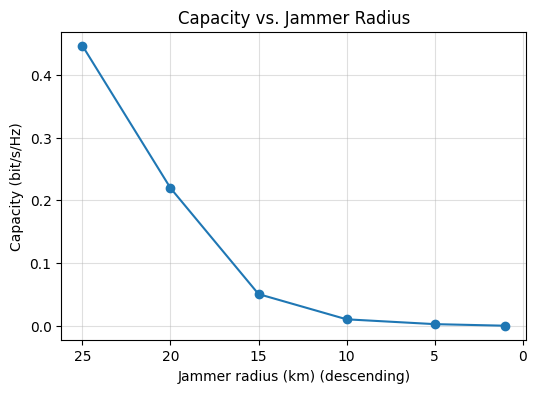

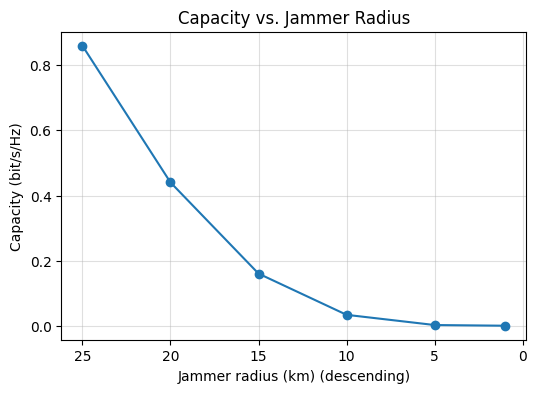

In [3]:


# =========================
# 2×3 radio-map panel (with shared color scale)
# =========================

# fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
# axes = axes.ravel()

# for i, r_km in enumerate(radii_km):
#     ax = axes[i]
#     im = ax.imshow(
#         images_by_radius[i],
#         origin="lower",
#         extent=extent_km,
#         aspect="equal",
#         # cmap="viridis",        # 可选，统一配色
#     )
#     ax.set_title(titles_by_radius[i], fontsize=10)
#     ax.set_xlabel("East (km)")
#     ax.set_ylabel("North (km)")

#     # overlay jammer ring and TX marker
#     ax.scatter(0.0, 0.0, marker='x', c='black', label='User TX')
#     circle = make_ground_positions(radii_km[i])[1:, :2] / 1e3
#     ax.scatter(circle[:, 0], circle[:, 1], c='red', s=20, marker='x', label='Jammers')
#     if i == 0:
#         ax.legend(loc="upper right", fontsize=8)

#     # === 每个子图单独 colorbar ===
#     cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     cbar.set_label("Path gain (dB)")

# fig.suptitle("Beamforming/Nulling Radio Maps across Jammer Radii", fontsize=12)
# plt.show()



# =========================
# Capacity vs radius (DESCENDING order)
# =========================
r_desc = list(sorted(radii_km, reverse=True))
# match capacities in that order
cap_desc = [cap_by_radius[radii_km.index(r)] for r in r_desc]

plt.figure(figsize=(6, 4))
plt.plot(r_desc, cap_desc, marker='o')
plt.gca().invert_xaxis()  # 25 -> ... -> 1 visually from left to right if you prefer
plt.xlabel("Jammer radius (km) (descending)")
plt.ylabel("Capacity (bit/s/Hz)")
plt.title("Capacity vs. Jammer Radius")
plt.grid(True, alpha=0.4)
plt.show()




cap_desc2 = [cap_by_radius2[radii_km.index(r)] for r in r_desc]

plt.figure(figsize=(6, 4))
plt.plot(r_desc, cap_desc2, marker='o')
plt.gca().invert_xaxis()  # 25 -> ... -> 1 visually from left to right if you prefer
plt.xlabel("Jammer radius (km) (descending)")
plt.ylabel("Capacity (bit/s/Hz)")
plt.title("Capacity vs. Jammer Radius")
plt.grid(True, alpha=0.4)
plt.show()


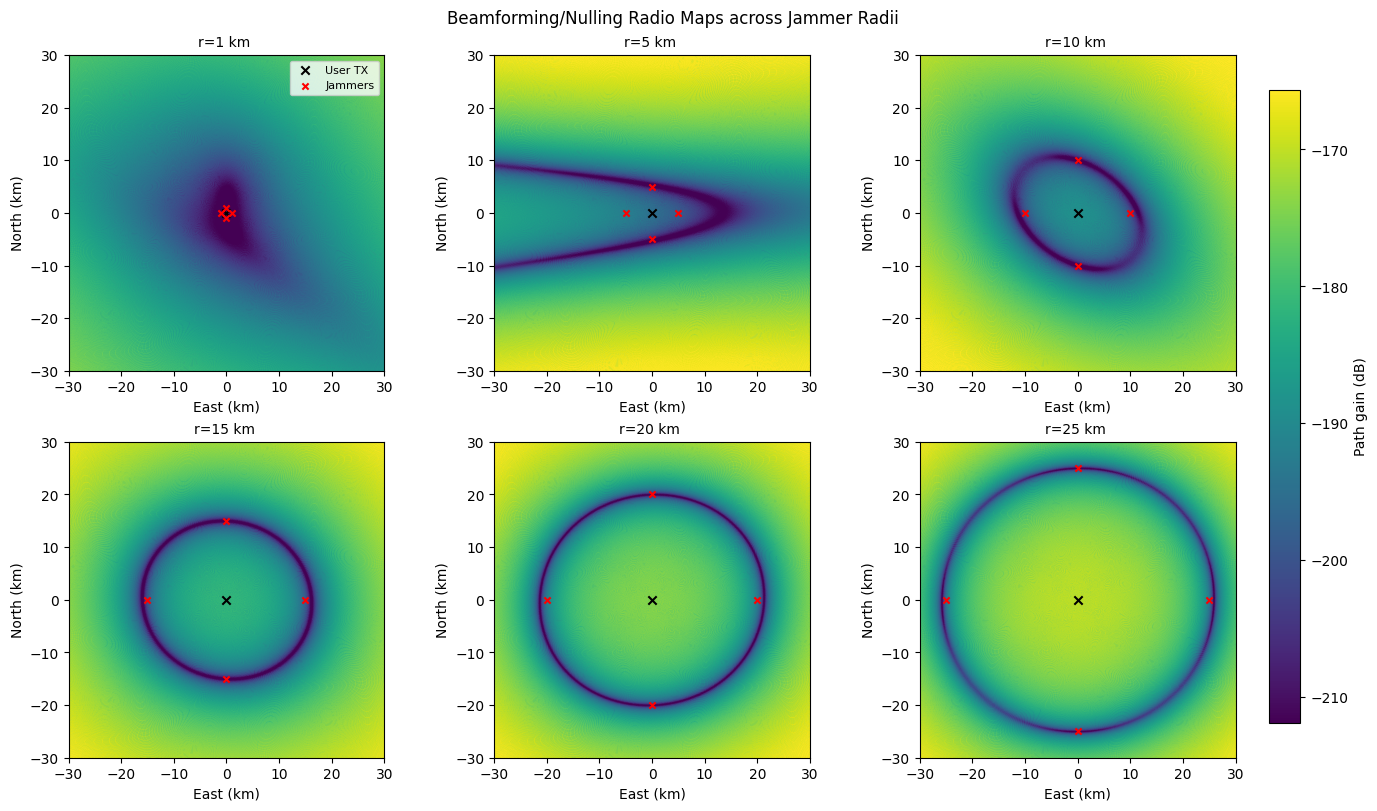

In [4]:
# =========================
# 2×3 radio-map panel (single shared colorbar)
# =========================
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
axes = axes.ravel()

# ---- 1. Compute global vmin/vmax ----
all_vals = np.concatenate([img.ravel() for img in images_by_radius])
vmin = np.nanpercentile(all_vals, 1)   # or np.nanmin(all_vals)
vmax = np.nanpercentile(all_vals, 99)  # or np.nanmax(all_vals)
# optional manual override, e.g. vmin, vmax = -150, -60

# ---- 2. Shared normalization ----
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"  # or whatever you prefer

# ---- 3. Plot each subplot ----
for i, r_km in enumerate(radii_km):
    ax = axes[i]
    im = ax.imshow(
        images_by_radius[i],
        origin="lower",
        extent=extent_km,
        aspect="equal",
        cmap=cmap,
        norm=norm,
    )
    ax.set_title(titles_by_radius[i], fontsize=10)
    ax.set_xlabel("East (km)")
    ax.set_ylabel("North (km)")

    # overlay jammer ring and TX marker
    ax.scatter(0.0, 0.0, marker='x', c='black', label='User TX')
    circle = make_ground_positions(radii_km[i])[1:, :2] / 1e3
    ax.scatter(circle[:, 0], circle[:, 1], c='red', s=20, marker='x', label='Jammers')
    if i == 0:
        ax.legend(loc="upper right", fontsize=8)

# ---- 4. Single shared colorbar ----
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for older mpl versions
cbar = fig.colorbar(sm, ax=axes.tolist(), shrink=0.9, pad=0.02)
cbar.set_label("Path gain (dB)")

fig.suptitle("Beamforming/Nulling Radio Maps across Jammer Radii", fontsize=12)
plt.show()


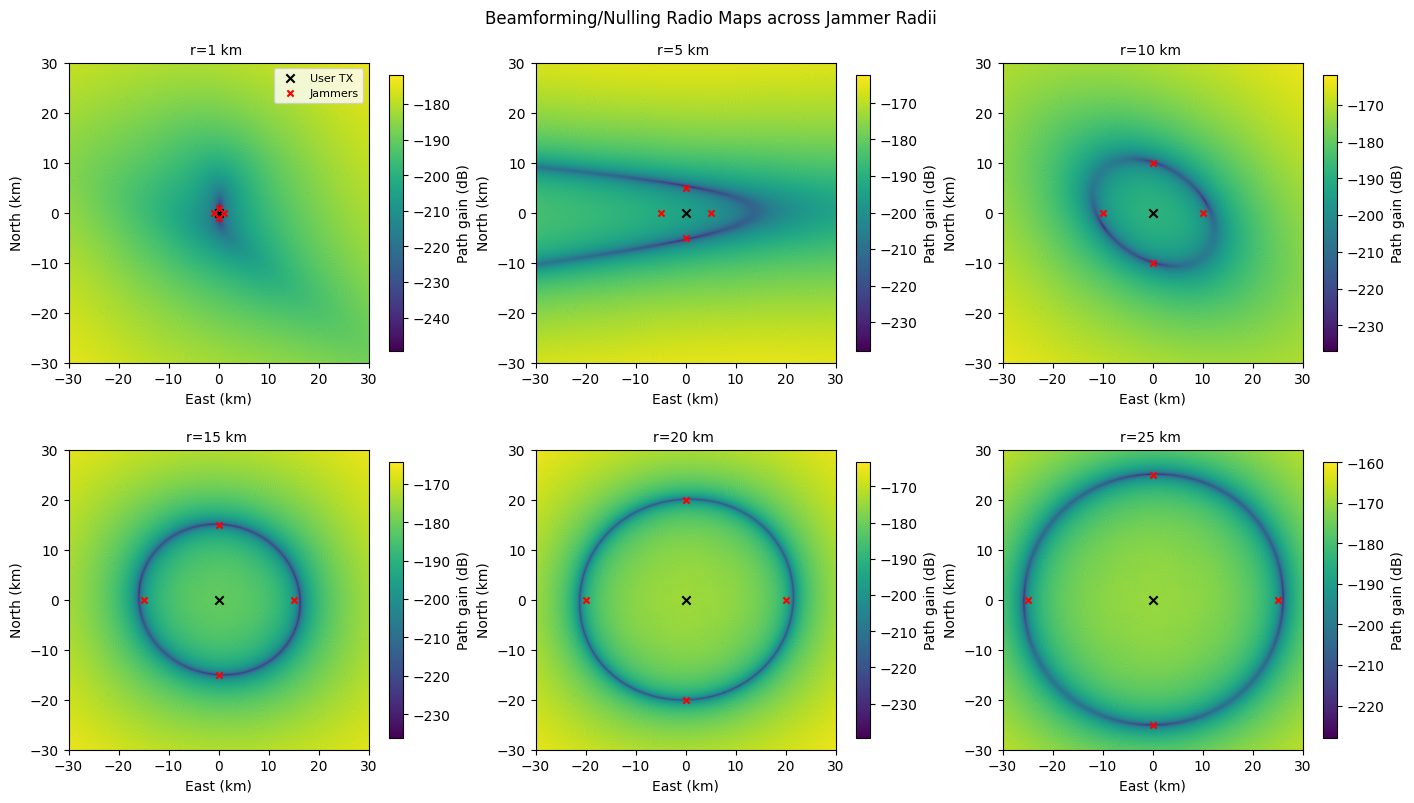

In [5]:
# =========================
# 2×3 radio-map panel (with shared color scale)
# =========================

fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
axes = axes.ravel()

for i, r_km in enumerate(radii_km):
    ax = axes[i]
    im = ax.imshow(
        images_by_radius[i],
        origin="lower",
        extent=extent_km,
        aspect="equal",
        # cmap="viridis",        # 可选，统一配色
    )
    ax.set_title(titles_by_radius[i], fontsize=10)
    ax.set_xlabel("East (km)")
    ax.set_ylabel("North (km)")

    # overlay jammer ring and TX marker
    ax.scatter(0.0, 0.0, marker='x', c='black', label='User TX')
    circle = make_ground_positions(radii_km[i])[1:, :2] / 1e3
    ax.scatter(circle[:, 0], circle[:, 1], c='red', s=20, marker='x', label='Jammers')
    if i == 0:
        ax.legend(loc="upper right", fontsize=8)

    # === 每个子图单独 colorbar ===
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Path gain (dB)")

fig.suptitle("Beamforming/Nulling Radio Maps across Jammer Radii", fontsize=12)
plt.show()